## EXPERIMENTOS CON FILTROS LINEALES

En este Notebook se hace una serie de experimetnos con los parámetros de los filtros lineales Notch y paso banda, para asegurar el correcto preprocesamiento que se aplicará más adelante a la señal de EEG.

IMPORT MODULES

In [1]:
import mne
from TFG_utils import returnFiles, take_vmrk_files, take_vhdr_files, take_eeg_files, plot_freq_response, plot_PSD, plot_eeg_channel_corrected, plot_residual_PSD, plot_spots
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

In [2]:
mne.__version__
#%matplotlib qt
verbose= False

COLLECTING DATA

In [3]:
foldername = 'EEG_folders'
EEG_files= returnFiles(foldername)

vmrk_files= take_vmrk_files(EEG_files)
vhdr_files= take_vhdr_files(EEG_files)
eeg_files= take_eeg_files(EEG_files)

i= 3 # Choosing EEG recording to use

vmrk_filename= vmrk_files[i]
vhdr_filename= vhdr_files[i]
eeg_filename= eeg_files[i]

In [4]:
raw_eeg = mne.io.read_raw_brainvision(vhdr_files[i],verbose=verbose).load_data(verbose=verbose)
data,times= raw_eeg[:]
info= raw_eeg.info
fs= int(info['sfreq'])

In [5]:
#Selecting channel to represent:
ch = 2 #Channel F3
#ch = 28 #Channel F4
#ch = 3 #Channel F7
#ch = 29 #Channel F8

In [6]:
subject= eeg_filename[-8:-4]
print('Sujeto:',subject)
print('Canal:', info['ch_names'][ch])

Sujeto: 2900
Canal: F3


## 1. HIGH PASS FILTER: Cutoff frequency

In [7]:
f1s=[0.1, 0.3, 0.5] # Cutoff frequencies

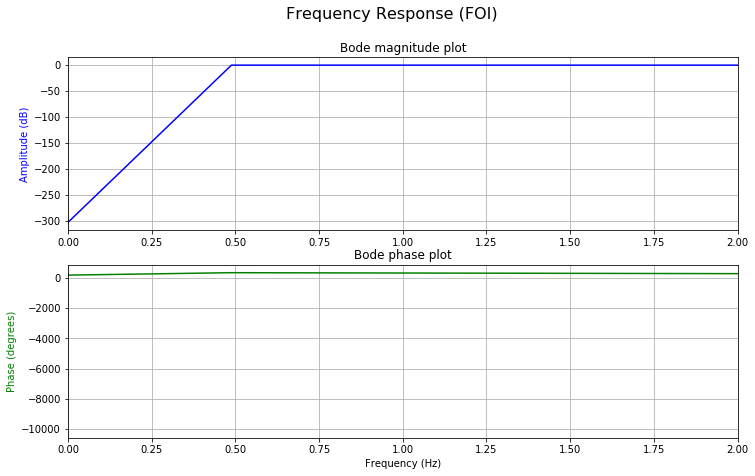

In [8]:
data, times = raw_eeg['all'][:]
b = mne.filter.create_filter(data, sfreq=fs, l_freq=f1s[0], h_freq=None, method='fir',
                             fir_window='hamming', fir_design='firwin', verbose= verbose)
plot_freq_response(b, 1, fs, xlim=2)

In [9]:
hp_filtered_01= raw_eeg.copy().set_montage("standard_1020", verbose= verbose) #Duda Rebeca montaje! ¿Me dijiste que en este casco no se utilizaba exactamente el montaje 10-20? 
hp_filtered_01.filter(l_freq=f1s[0], h_freq=None, method='fir',fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

hp_filtered_03= raw_eeg.copy().set_montage("standard_1020", verbose= verbose) 
hp_filtered_03.filter(l_freq=f1s[1], h_freq=None, method='fir', fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

hp_filtered_05= raw_eeg.copy().set_montage("standard_1020", verbose= verbose) 
hp_filtered_05.filter(l_freq=f1s[2], h_freq=None, method='fir', fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

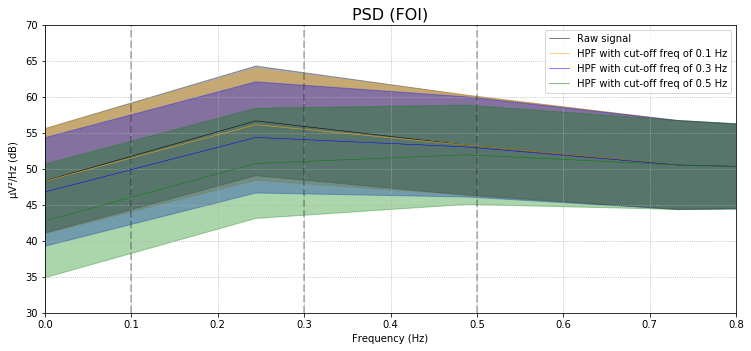

In [10]:
plt.figure(figsize=(12,5))
ax = plt.axes()

raw_eeg.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='black')
hp_filtered_01.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='orange')
hp_filtered_03.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='blue')
hp_filtered_05.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='green')

ax.set_xlim([0, 0.8])
ax.set_ylim([30, 70])
leg_lines = [line for line in ax.lines if line.get_linestyle() == '-']
plt.legend(leg_lines, ['Raw signal','HPF with cut-off freq of 0.1 Hz','HPF with cut-off freq of 0.3 Hz','HPF with cut-off freq of 0.5 Hz'])
ax.set_title('PSD (FOI)', fontsize=16)
plt.show()

c:\users\noemi\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


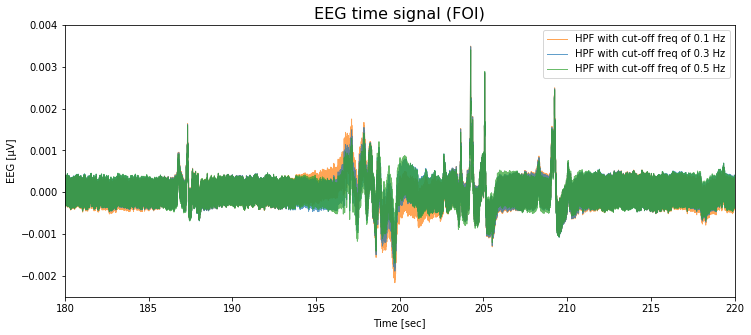

In [11]:
y1,x1=hp_filtered_01[:]
y2,x2=hp_filtered_03[:]
y3,x3=hp_filtered_05[:]

mysignals = [{'name': 'HPF with cut-off freq of 0.1 Hz', 'x': x1,
             'y': y1[ch], 'color':'tab:orange', 'alpha':0.7, 'linewidth':1},
            {'name': 'HPF with cut-off freq of 0.3 Hz', 'x': x2,
             'y': y2[ch], 'color':'tab:blue','alpha':0.7, 'linewidth':1},
            {'name': 'HPF with cut-off freq of 0.5 Hz', 'x': x3,
             'y': y3[ch], 'color':'tab:green','alpha':0.7, 'linewidth':1}]

fig, ax = plt.subplots(figsize=(12,5))
for signal in mysignals:
    ax.plot(signal['x'], signal['y'], 
            color=signal['color'], alpha=signal['alpha'],
            linewidth=signal['linewidth'],
            label=signal['name'])

# Enable legend
ax.legend()
ax.set_xlim([180, 220])
ax.set_ylim([-0.0025, 0.004])
ax.set_ylabel('EEG [µV]')
ax.set_xlabel('Time [sec]')
ax.set_title("EEG time signal (FOI)",fontsize=16)
plt.show()

We select a **cut-off frequency of 0.1 Hz**:

In [12]:
f1= 0.1
hp_filtered = raw_eeg.copy().set_montage("standard_1020", verbose= verbose) 
hp_filtered.filter(l_freq= f1, h_freq= None, method='fir', fir_window='hamming', 
                  fir_design='firwin', verbose= verbose)

<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

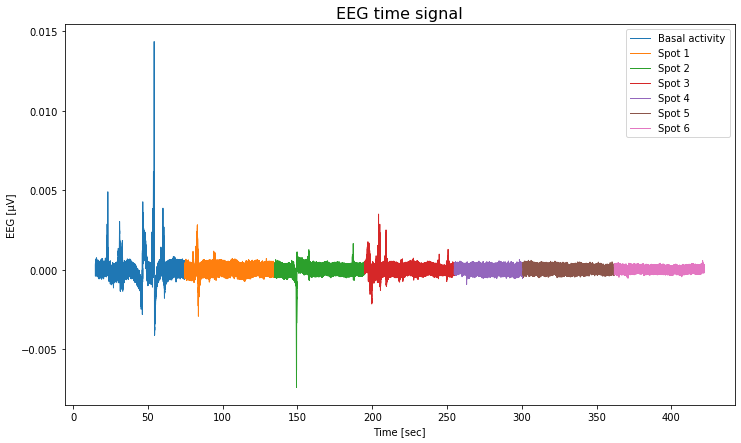

In [13]:
plot_spots(vmrk_filename, hp_filtered, ch)

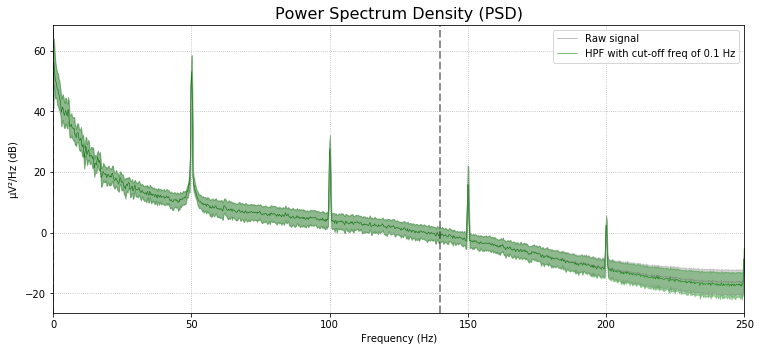

In [14]:
plt.figure(figsize=(12,5))
ax = plt.axes()

raw_eeg.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='grey')
hp_filtered.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='green')

leg_lines = [line for line in ax.lines if line.get_linestyle() == '-']
plt.legend(leg_lines, ['Raw signal','HPF with cut-off freq of 0.1 Hz'])
ax.set_title('Power Spectrum Density (PSD)', fontsize=16)
plt.show()

# 2. LOW PASS FILTER (FIR)

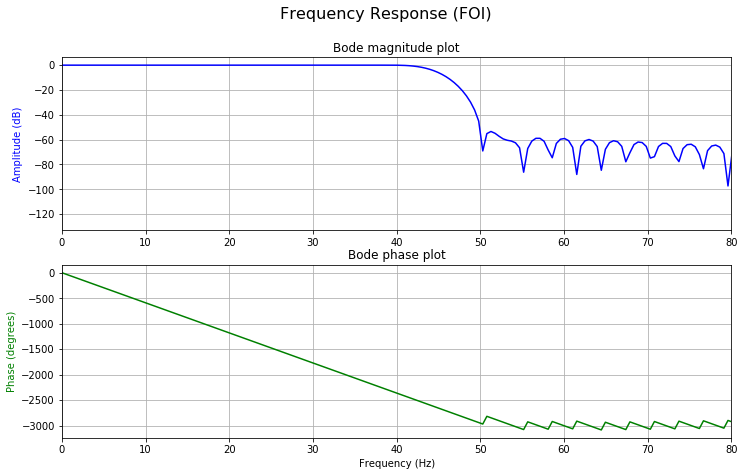

In [15]:
data, times = hp_filtered['all'][:]
b = mne.filter.create_filter(data, sfreq=fs, l_freq=None, h_freq=40, method='fir',
                             fir_window='hamming', filter_length='auto',fir_design='firwin', verbose= verbose)
plot_freq_response(b, 1, fs, xlim=80)

In [16]:
lp_filtered_01= hp_filtered.copy().set_montage("standard_1020", verbose= verbose)
lp_filtered_01.filter(l_freq=None, filter_length='auto', h_freq=40, method='fir',fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

lp_filtered_03= hp_filtered.copy().set_montage("standard_1020", verbose= verbose) 
lp_filtered_03.filter(l_freq=None, filter_length='50s', h_freq=40, method='fir', fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

lp_filtered_05= hp_filtered.copy().set_montage("standard_1020", verbose= verbose) 
lp_filtered_05.filter(l_freq=None, filter_length='500s', h_freq=40, method='fir', fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

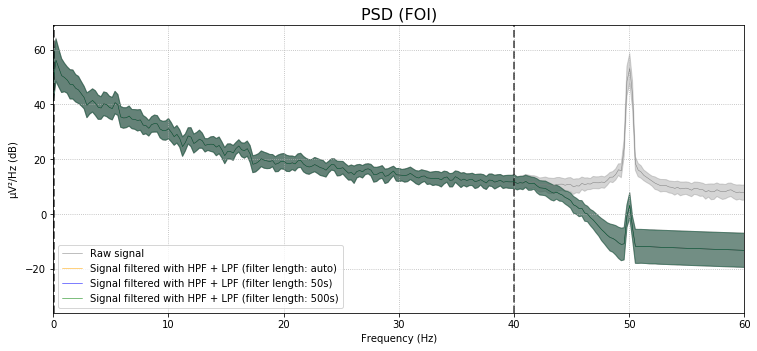

In [17]:
plt.figure(figsize=(12,5))
ax = plt.axes()

raw_eeg.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='grey')
lp_filtered_01.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='orange')
lp_filtered_03.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='blue')
lp_filtered_05.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='green')

leg_lines = [line for line in ax.lines if line.get_linestyle() == '-']
plt.legend(leg_lines, ['Raw signal','Signal filtered with HPF + LPF (filter length: auto)','Signal filtered with HPF + LPF (filter length: 50s)','Signal filtered with HPF + LPF (filter length: 500s)'])
ax.set_xlim([0, 60])
ax.set_title('PSD (FOI)', fontsize=16)
plt.show()

# 3. BAND PASS FILTER (FIR)

In [18]:
f1,f2=(0.1,40)

In [19]:
bp_filtered_01= raw_eeg.copy().set_montage("standard_1020", verbose= verbose)
bp_filtered_01.filter(l_freq=f1, filter_length='auto', h_freq=f2, method='fir',fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

bp_filtered_03= raw_eeg.copy().set_montage("standard_1020", verbose= verbose) 
bp_filtered_03.filter(l_freq=f1, filter_length='50s', h_freq=f2, method='fir', fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

bp_filtered_05= raw_eeg.copy().set_montage("standard_1020", verbose= verbose) 
bp_filtered_05.filter(l_freq=f1, filter_length='500s', h_freq=f2, method='fir', fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

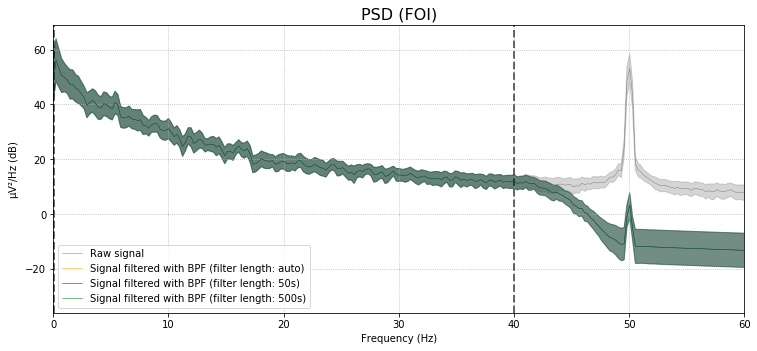

In [20]:
plt.figure(figsize=(12,5))
ax = plt.axes()

raw_eeg.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='grey')
bp_filtered_01.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='orange')
bp_filtered_03.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='blue')
bp_filtered_05.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='green')

leg_lines = [line for line in ax.lines if line.get_linestyle() == '-']
plt.legend(leg_lines, ['Raw signal','Signal filtered with BPF (filter length: auto)','Signal filtered with BPF (filter length: 50s)','Signal filtered with BPF (filter length: 500s)'])
ax.set_xlim([0, 60])
ax.set_title('PSD (FOI)', fontsize=16)
plt.show()

#### Comparison between HPF+LPF and BPF:

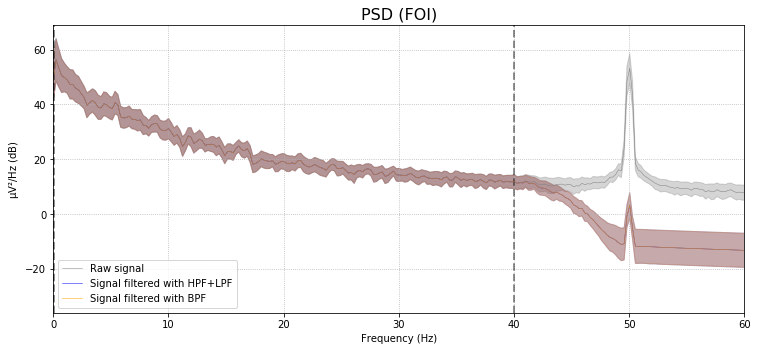

In [21]:
plt.figure(figsize=(12,5))
ax = plt.axes()

raw_eeg.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='grey')
lp_filtered_01.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='blue')
bp_filtered_01.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='orange')

leg_lines = [line for line in ax.lines if line.get_linestyle() == '-']
plt.legend(leg_lines, ['Raw signal','Signal filtered with HPF+LPF','Signal filtered with BPF'])
ax.set_xlim([0, 60])
ax.set_title('PSD (FOI)', fontsize=16)
plt.show()

We select a **BPF** with lower cut-off frequency of **0.1 Hz** and **auto** filter length:

In [22]:
f1,f2=(0.1,40)

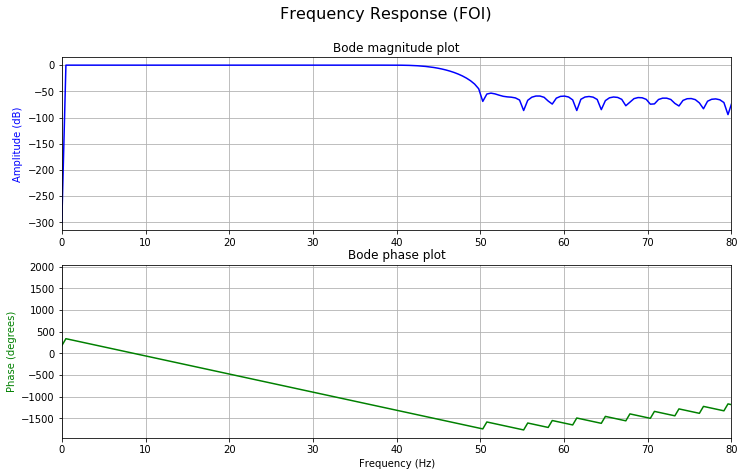

In [23]:
data, times = raw_eeg['all'][:]
 
b = mne.filter.create_filter(data, l_freq=f1, h_freq=f2, filter_length='auto', sfreq=fs, method='fir',
                             fir_window='hamming', fir_design='firwin', verbose= verbose)
plot_freq_response(b, 1, fs, xlim=80)

In [24]:
bp_filtered= raw_eeg.copy().set_montage("standard_1020", verbose= verbose)
bp_filtered.filter(l_freq=f1, h_freq=f2, filter_length='auto', method='fir',fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)

<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

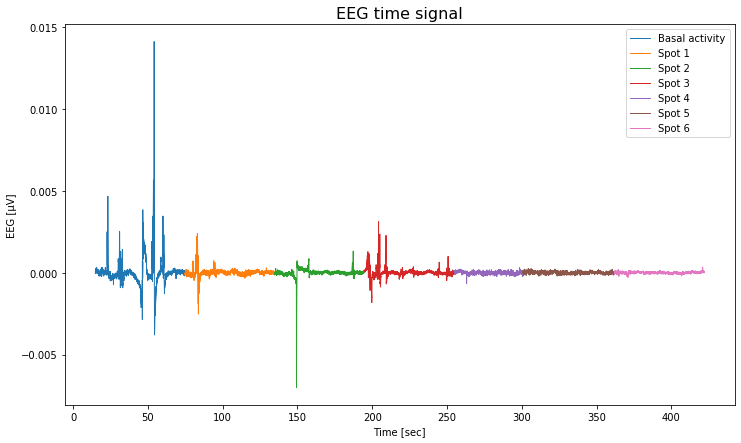

In [25]:
plot_spots(vmrk_filename, bp_filtered, ch)

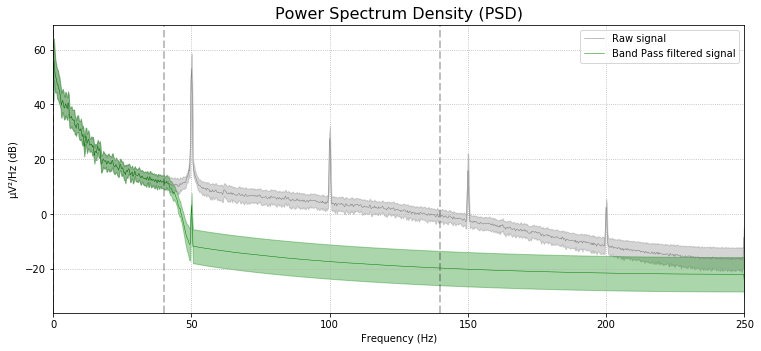

In [26]:
plt.figure(figsize=(12,5))
ax = plt.axes()

raw_eeg.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='grey')
bp_filtered.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='green')

leg_lines = [line for line in ax.lines if line.get_linestyle() == '-']
plt.legend(leg_lines, ['Raw signal','Band Pass filtered signal'])
ax.set_title('Power Spectrum Density (PSD)', fontsize=16)
plt.show()

# 4. NOTCH FILTER

In [27]:
notch_filtered_auto= bp_filtered.copy().set_montage("standard_1020", verbose= verbose) #Duda Rebeca montaje! ¿Me dijiste que en este casco no se utilizaba exactamente el montaje 10-20? 
notch_filtered_auto.notch_filter([50,100,150], filter_length='auto', method='fir', fir_window='hamming', fir_design='firwin', verbose=None)

notch_filtered_50= bp_filtered.copy().set_montage("standard_1020", verbose= verbose) #Duda Rebeca montaje! ¿Me dijiste que en este casco no se utilizaba exactamente el montaje 10-20? 
notch_filtered_50.notch_filter([50,100,150], filter_length='50s', method='fir', fir_window='hamming', fir_design='firwin', verbose=None)

notch_filtered_500= bp_filtered.copy().set_montage("standard_1020", verbose= verbose) #Duda Rebeca montaje! ¿Me dijiste que en este casco no se utilizaba exactamente el montaje 10-20? 
notch_filtered_500.notch_filter([50,100,150], filter_length='500s', method='fir', fir_window='hamming', fir_design='firwin', verbose=None)

<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

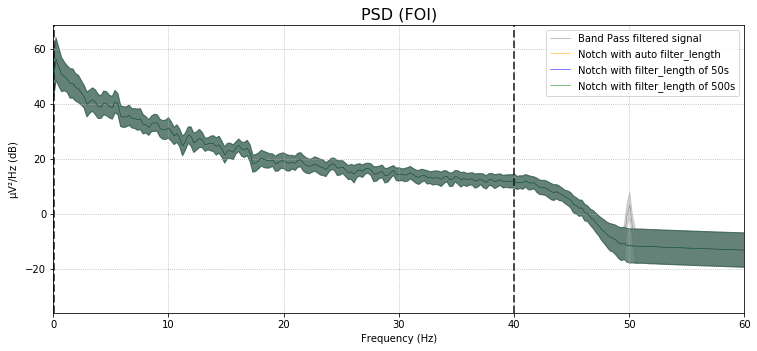

In [28]:
plt.figure(figsize=(12,5))
ax = plt.axes()

bp_filtered.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='grey')
notch_filtered_auto.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='orange')
notch_filtered_50.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='blue')
notch_filtered_500.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='green')

leg_lines = [line for line in ax.lines if line.get_linestyle() == '-']
plt.legend(leg_lines, ['Band Pass filtered signal','Notch with auto filter_length','Notch with filter_length of 50s','Notch with filter_length of 500s'])
ax.set_title('PSD (FOI)', fontsize=16)
ax.set_xlim([0, 60])
plt.show()

We select the **auto** filter_length:

In [29]:
sig_filtered= bp_filtered.copy().set_montage("standard_1020", verbose= verbose)
sig_filtered.notch_filter([50,100,150], filter_length='auto', method='fir', fir_window='hamming', fir_design='firwin', verbose=None)

<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

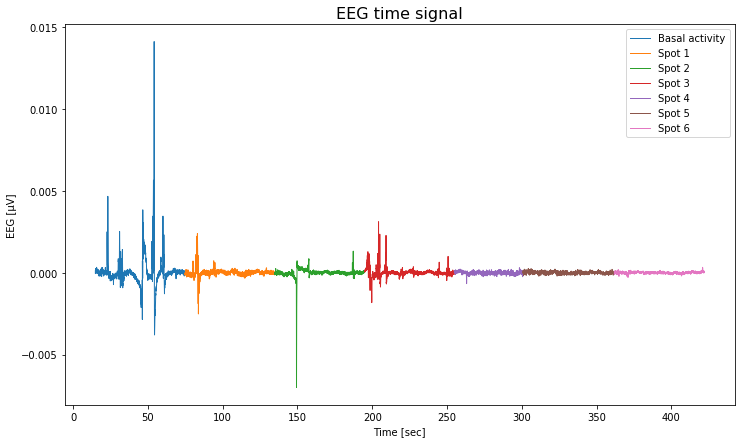

In [30]:
plot_spots(vmrk_filename, sig_filtered, ch)

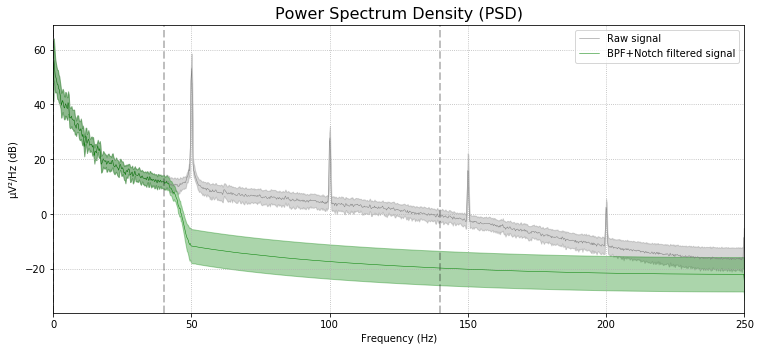

In [31]:
plt.figure(figsize=(12,5))
ax = plt.axes()

raw_eeg.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='grey')
sig_filtered.plot_psd(area_mode='std', ax=ax, dB=True, show=False, average=True, estimate='power', line_alpha=None, color='green')

leg_lines = [line for line in ax.lines if line.get_linestyle() == '-']
plt.legend(leg_lines, ['Raw signal','BPF+Notch filtered signal'])
ax.set_title('Power Spectrum Density (PSD)', fontsize=16)
plt.show()

### RUTINA FINAL DE FILTRADO

In [32]:
f1,f2=(0.1,40)
eeg_filtered= raw_eeg.copy().set_montage("standard_1020", verbose= verbose)
eeg_filtered.filter(l_freq=f1, h_freq=f2, filter_length='auto', method='fir',fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)
eeg_filtered.notch_filter([50,100,150], filter_length='auto', method='fir', fir_window='hamming', fir_design='firwin', verbose=None)

<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>